# CSC12107 - HỆ THỐNG THÔNG TIN PHỤC VỤ TRÍ TUỆ KINH DOANH - #CQ2021/21
# MINING DATA WAREHOUSE

## Group: CQ.BI.2425.02

Import packages

In [1]:
import pyodbc
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
from dotenv import load_dotenv
import os
warnings.filterwarnings('ignore')

Chuẩn bị các thành phần đến DDS database

In [2]:
load_dotenv()

server              = os.getenv('SERVER')
database            = os.getenv('DATABASE')
username            = os.getenv('USERNAME')
password            = os.getenv('PASSWORD')
driver              = os.getenv('DRIVER')

In [3]:
connection_string = f"""
    DRIVER={driver};
    SERVER={server};
    DATABASE={database};
    UID={username};
    PWD={password};
    Trusted_Connection=yes;
"""

Truy vấn dữ liệu từ DDS

In [4]:
try:
    # Establish connection
    conn = pyodbc.connect(connection_string)
    print("Connection Successful!")
    
    # Create a cursor
    cursor = conn.cursor()
    
    query = f"""
        SELECT c.county_name, 
            s.state_name, 
            d.date, 
            f.aqi_value, 
            ca.level_of_concern, 
            ca.daily_aqi_color, 
            p.parameter_name
        FROM FACT_AIR_QUALITY f
        JOIN DIM_COUNTY c ON f.county_key=c.county_key
        JOIN DIM_STATE s ON s.state_key = c.state_key
        JOIN DIM_DATE d ON f.date_key = d.date_key
        JOIN DIM_CATEGORY ca ON ca.category_key = F.category_key
        JOIN DIM_PARAMETER p on p.parameter_key = f.defining_parameter_key
    """
    df = pd.read_sql_query(query, conn)
    print("Query Results:")
    print(df)

    cursor.close()
    conn.close()
except Exception as e:
    print("Error:", e)

Connection Successful!
Query Results:
                 county_name  state_name        date  aqi_value  \
0                 New Castle    Delaware  2023-03-26         35   
1                      Lucas        Ohio  2023-08-30         34   
2                    Trinity  California  2021-05-22         22   
3                    Kaufman       Texas  2022-12-05         36   
4                     Colusa  California  2023-03-24         38   
...                      ...         ...         ...        ...   
134894  Fairbanks North Star      Alaska  2021-01-08        169   
134895  Fairbanks North Star      Alaska  2021-01-01        189   
134896  Fairbanks North Star      Alaska  2021-01-27        163   
134897  Fairbanks North Star      Alaska  2021-01-09        174   
134898  Fairbanks North Star      Alaska  2021-01-13        163   

       level_of_concern daily_aqi_color parameter_name  
0                  Good           Green          Ozone  
1                  Good           Green    

In [5]:
df.to_csv('aqi.csv', header=True, index=False)
df

,county_name,state_name,date,aqi_value,level_of_concern,daily_aqi_color,parameter_name
0,New Castle,Delaware,2023-03-26,35,Good,Green,Ozone
1,Lucas,Ohio,2023-08-30,34,Good,Green,Ozone
2,Trinity,California,2021-05-22,22,Good,Green,PM2.5
3,Kaufman,Texas,2022-12-05,36,Good,Green,PM2.5
4,Colusa,California,2023-03-24,38,Good,Green,Ozone
...,...,...,...,...,...,...,...
134894,Fairbanks North Star,Alaska,2021-01-08,169,Unhealthy,Red,PM2.5
134895,Fairbanks North Star,Alaska,2021-01-01,189,Unhealthy,Red,PM2.5
134896,Fairbanks North Star,Alaska,2021-01-27,163,Unhealthy,Red,PM2.5
134897,Fairbanks North Star,Alaska,2021-01-09,174,Unhealthy,Red,PM2.5


Parse cột date thành kiểu DateTime

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

In [7]:
df.describe()

,date,aqi_value
count,134899,134899.000000
mean,2022-04-10 01:55:42.153759232,44.031090
min,2021-01-01 00:00:00,0.000000
25%,2021-07-10 00:00:00,31.000000
50%,2022-02-01 00:00:00,41.000000
75%,2023-01-05 00:00:00,53.000000
max,2023-12-31 00:00:00,500.000000
std,NaN,23.318228


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134899 entries, 0 to 134898
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   county_name       134899 non-null  object        
 1   state_name        134899 non-null  object        
 2   date              134899 non-null  datetime64[ns]
 3   aqi_value         134899 non-null  int64         
 4   level_of_concern  134899 non-null  object        
 5   daily_aqi_color   134899 non-null  object        
 6   parameter_name    134899 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.2+ MB


## Dự đoán chỉ số AQI quận Lucas thuộc bang Ohio cho 30 ngày sắp tới.

Lấy ra những dòng dữ liệu liên quan đến quận Lucas (Ohio)

In [9]:
new_castle_df = df[
    (df['county_name'] == 'Lucas') & 
    (df['state_name'] == 'Ohio')
]

new_castle_df

,county_name,state_name,date,aqi_value,level_of_concern,daily_aqi_color,parameter_name
1,Lucas,Ohio,2023-08-30,34,Good,Green,Ozone
6,Lucas,Ohio,2022-07-08,30,Good,Green,Ozone
103,Lucas,Ohio,2021-11-28,37,Good,Green,PM2.5
278,Lucas,Ohio,2023-04-04,50,Good,Green,Ozone
402,Lucas,Ohio,2023-01-07,46,Good,Green,Ozone
...,...,...,...,...,...,...,...
127205,Lucas,Ohio,2021-05-18,115,Unhealthy for Sensitive Groups,Orange,Ozone
127695,Lucas,Ohio,2021-07-28,119,Unhealthy for Sensitive Groups,Orange,Ozone
128138,Lucas,Ohio,2021-05-19,122,Unhealthy for Sensitive Groups,Orange,Ozone
128174,Lucas,Ohio,2021-05-20,115,Unhealthy for Sensitive Groups,Orange,Ozone


Lấy giá trị AQI trung bình theo từng ngày của Lucas (Ohio)

In [10]:
new_castle_grouped = new_castle_df.groupby('date', as_index=False)['aqi_value'].mean()

In [11]:
fig = px.line(
    new_castle_grouped, 
    x='date', 
    y='aqi_value', 
    title='Average AQI Value by Date',
    labels={'aqi_value': 'Average AQI Value', 'date': 'Date'},
    line_shape='linear'
)
fig.show()

Set index cho DataFrame là cột date

In [12]:
new_castle_grouped.set_index("date", inplace=True)
new_castle_grouped = new_castle_grouped.asfreq('D')
new_castle_grouped

,aqi_value
date,
2021-01-01,41.0
2021-01-02,28.0
2021-01-03,32.0
2021-01-04,54.0
2021-01-05,52.0
...,...
2023-12-26,28.0
2023-12-27,25.0
2023-12-28,29.0


Fill NaN bằng các giá trị mặc định

In [13]:
new_castle_grouped = new_castle_grouped.fillna(method='ffill')

### Kiểm tra tính dừng

**Kiểm định Augmented Dicky Fuller**
* Kiểm định Augmented Dickey-Fuller là một loại kiểm định thống kê còn được gọi là kiểm định đơn vị. Nền tảng của kiểm định đơn vị là giúp xác định mức độ mà một chuỗi thời gian được xác định bởi xu hướng (trend). 
* Giả thuyết gốc của kiểm định là chuỗi thời gian có thể được biểu diễn bởi một đơn vị root, tức là nó không dừng. Giả thuyết thay thế (bác bỏ giả thuyết gốc) là chuỗi thời gian dừng.

    1. Giả thuyết gốc (H0): Chuỗi thời gian không dừng.
    2. Giả thuyết thay thế (H1): Chuỗi thời gian dừng.
* Kết quả được diễn giải dựa trên giá trị p (p-value) từ kiểm định.

    1. p-value > 0.05: Không bác bỏ giả thuyết gốc (H0), dữ liệu không dừng.
    2. p-value <= 0.05: Bác bỏ giả thuyết gốc (H0), dữ liệu có tính dừng.

In [14]:
from statsmodels.tsa.stattools import adfuller 

adf = adfuller(new_castle_grouped['aqi_value'])

print(adf)
print('\nADF = ', str(adf[0])) #more towards negative value the better
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)
    

    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')


(np.float64(-15.35591914639357), np.float64(3.6669618228673492e-28), 0, 1093, {'1%': np.float64(-3.4363470029475525), '5%': np.float64(-2.864187948086107), '10%': np.float64(-2.568179853605536)}, np.float64(8168.840600875465))

ADF =  -15.35591914639357

p-value =  3.6669618228673492e-28

Critical Values: 
1% : -3.4363470029475525
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.864187948086107
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.568179853605536
Null Hypothesis Rejected. Time Series is Stationary


Biểu diễn seasonal decomposition của chuỗi thời gian để tách thành 3 thành phần chính: trend, seasonality, và residuals

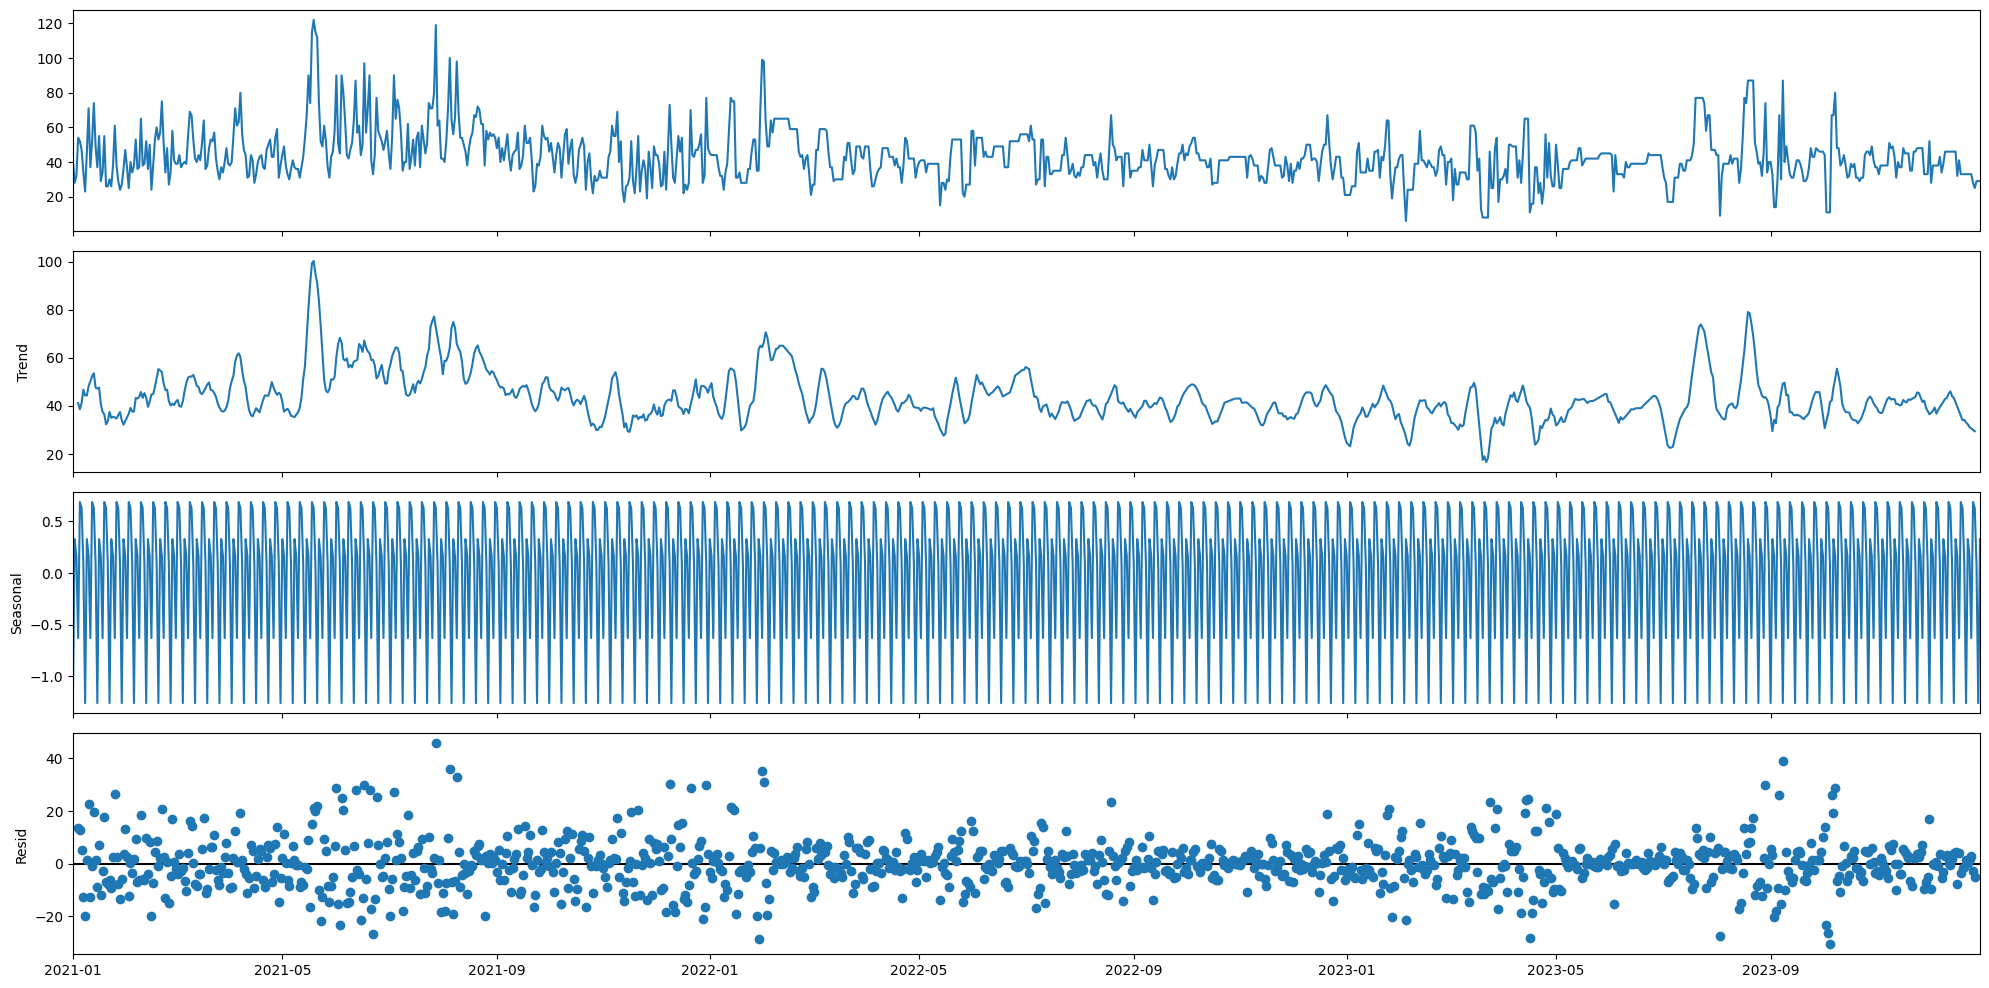

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(new_castle_grouped, model='additive')
fig = decomposition.plot()
fig.show()

### Huấn luyện mô hình SARIMA

## __Mô hình SARIMA__

Seasonal Autoregressive Integrated Moving Average (SARIMA), hay còn gọi là Seasonal ARIMA, là một mở rộng của mô hình ARIMA hỗ trợ dữ liệu chuỗi thời gian đơn biến có thành phần season.

SARIMA yêu cầu xác định các siêu tham số cho cả thành phần xu hướng và thành phần seasonal của chuỗi thời gian.

1. Có ba thành phần xu hướng cần được đảm bảo <br>
p: Bậc tự hồi quy của xu hướng (Trend autoregression order). d: Bậc sai phân của xu hướng (Trend difference order). q: Bậc trung bình trượt của xu hướng (Trend moving average order).

2. Thành phần mùa vụ (Seasonal Elements) 
Có bốn thành phần mùa vụ:
    * P: Bậc tự hồi quy của mùa vụ (Seasonal autoregressive order). <br> 
    * D: Bậc sai phân của mùa vụ (Seasonal difference order). 
    * Q: Bậc trung bình trượt của mùa vụ (Seasonal moving average order). 
    * m: Số bước thời gian trong một chu kỳ mùa vụ (The number of time steps for a single seasonal period).

### Ký hiệu mô hình SARIMA
Mô hình SARIMA được ký hiệu dưới dạng:
SARIMA(p,d,q)(P,D,Q)m

__Xác định tổ hợp tham số season tốt nhất cho mô hình SARIMA__

Tổ hợp tốt nhất cho mô hình SARIMA nên có giá trị AIC nhỏ nhất.

* Akaike Information Criterion (AIC) là một ước lượng của lỗi dự đoán ngoài mẫu và qua đó đánh giá chất lượng tương đối của các mô hình thống kê đối với một tập dữ liệu nhất định. AIC ước tính lượng thông tin bị mất tương đối bởi một mô hình cụ thể. Mô hình mất càng ít thông tin thì chất lượng của nó càng cao.
* Vì vậy, chúng ta nên chọn tổ hợp tham số có giá trị AIC nhỏ nhất.

In [16]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print(f"p, d, q combinations: {pdq}")
seasonal_pdq_comb = [(i[0], i[1], i[2], 30) for i in pdq] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

p, d, q combinations: [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 30)
SARIMA: (0, 0, 1) x (0, 1, 0, 30)
SARIMA: (0, 1, 0) x (0, 1, 1, 30)
SARIMA: (0, 1, 0) x (1, 0, 0, 30)


__Xác định tổ hợp tham số season tốt nhất cho mô hình SARIMA__

Tổ hợp tốt nhất cho mô hình SARIMA nên có giá trị AIC nhỏ nhất.

* Akaike Information Criterion (AIC) là một ước lượng của lỗi dự đoán ngoài mẫu và qua đó đánh giá chất lượng tương đối của các mô hình thống kê đối với một tập dữ liệu nhất định. AIC ước tính lượng thông tin bị mất tương đối bởi một mô hình cụ thể. Mô hình mất càng ít thông tin thì chất lượng của nó càng cao.
* Vì vậy, chúng ta nên chọn tổ hợp tham số có giá trị AIC nhỏ nhất.

In [17]:
for parameters in pdq:
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_castle_grouped,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{}30 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:11458.533196698381


SARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:11458.533196698381
SARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:10359.732164836296
SARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:10359.732164836296
SARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(0, 1, 0, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(0, 1, 1, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(1, 0, 0, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(1, 0, 1, 30)30 - AIC:8562.078540805667
SARIMA(0, 1, 0)x(1, 1, 0, 30)30 - AIC

Chúng ta sẽ chọn mô hình SARIMA(1, 1, 1)x(1, 1, 1, 12)30 vì nó có giá trị AIC nhỏ nhất.
<br>
Bây giờ, chúng ta sẽ tiến hành huấn luyện mô hình trên dữ liệu.

In [18]:
mod = sm.tsa.statespace.SARIMAX(new_castle_grouped,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 30)) #model defintion
results = mod.fit(disp=False) #model fitting

### Đánh giá model

In [19]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          aqi_value   No. Observations:                 1094
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -4093.254
Date:                            Sun, 29 Dec 2024   AIC                           8196.508
Time:                                    11:03:29   BIC                           8221.353
Sample:                                01-01-2021   HQIC                          8205.923
                                     - 12-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5944      0.020     29.766      0.000       0.555       0.634
ma.L1         -0.9786      0.007   

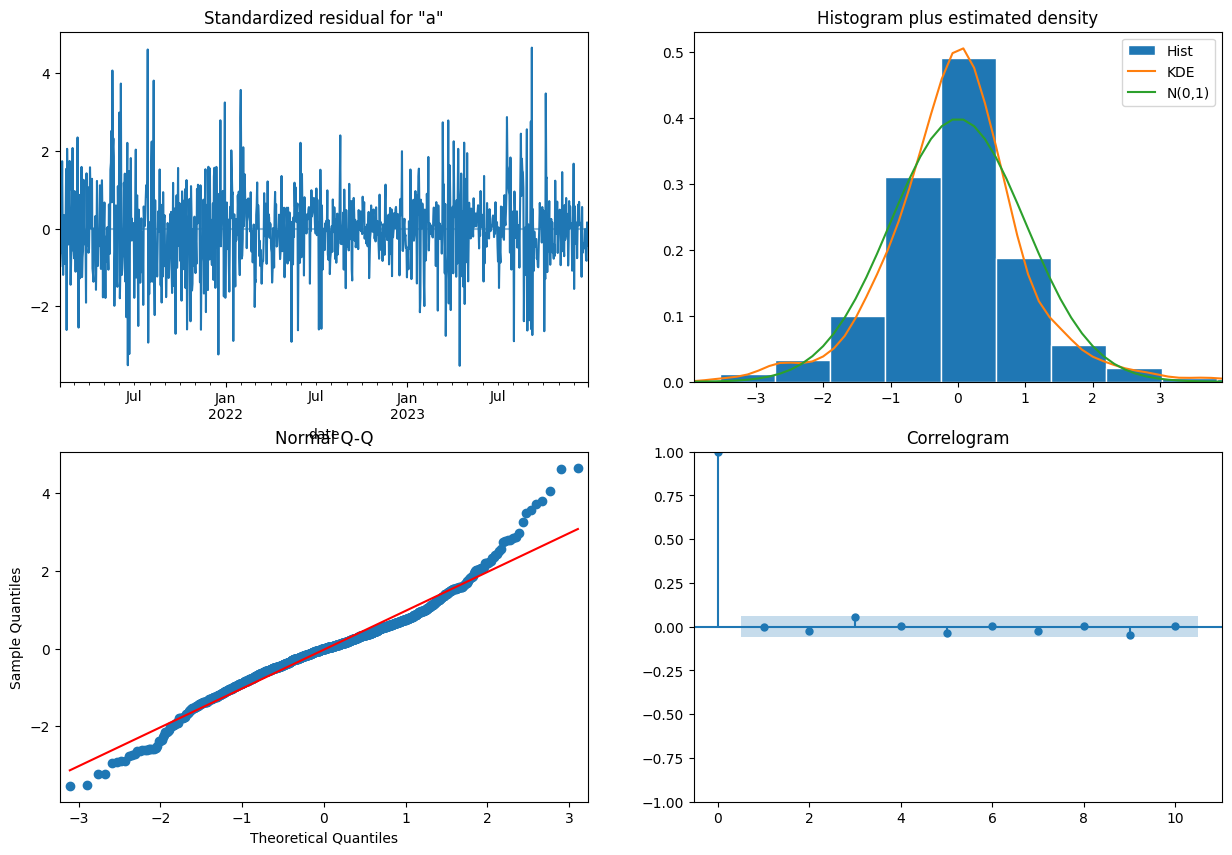

In [20]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

### Thực hiện dự đoán

Dự đoán tổng doanh thu cho 30 ngày tiếp theo

In [21]:
forecast = results.get_forecast(steps=30)  # Forecast the next 12 months
forecast_index = pd.date_range(start=new_castle_grouped.index[-1] + pd.DateOffset(days=1), periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

In [22]:
forecast_series

2023-12-31    33.205644
2024-01-01    30.084020
2024-01-02    32.490323
2024-01-03    35.417081
2024-01-04    39.506081
2024-01-05    38.486953
2024-01-06    41.264597
2024-01-07    37.485381
2024-01-08    39.506541
2024-01-09    39.218334
2024-01-10    40.631884
2024-01-11    36.151782
2024-01-12    36.700543
2024-01-13    38.330320
2024-01-14    39.576017
2024-01-15    40.142703
2024-01-16    38.819398
2024-01-17    38.646611
2024-01-18    35.856580
2024-01-19    38.210354
2024-01-20    39.792412
2024-01-21    40.131584
2024-01-22    41.131104
2024-01-23    36.488318
2024-01-24    37.645533
2024-01-25    37.388181
2024-01-26    37.623179
2024-01-27    35.873766
2024-01-28    37.283901
2024-01-29    33.691454
Freq: D, dtype: float64

Lấy khoảng tin cậy.

In [23]:
conf_int = forecast.conf_int()

In [24]:
conf_int

,lower aqi_value,upper aqi_value
2023-12-31,11.568969,54.842320
2024-01-01,4.673120,55.494921
2024-01-02,5.731730,59.248916
2024-01-03,8.109480,62.724683
2024-01-04,11.948639,67.063524
2024-01-05,10.800996,66.172910
2024-01-06,13.503033,69.026161
2024-01-07,9.672990,65.297772
2024-01-08,11.655717,67.357365
2024-01-09,11.335621,67.101046


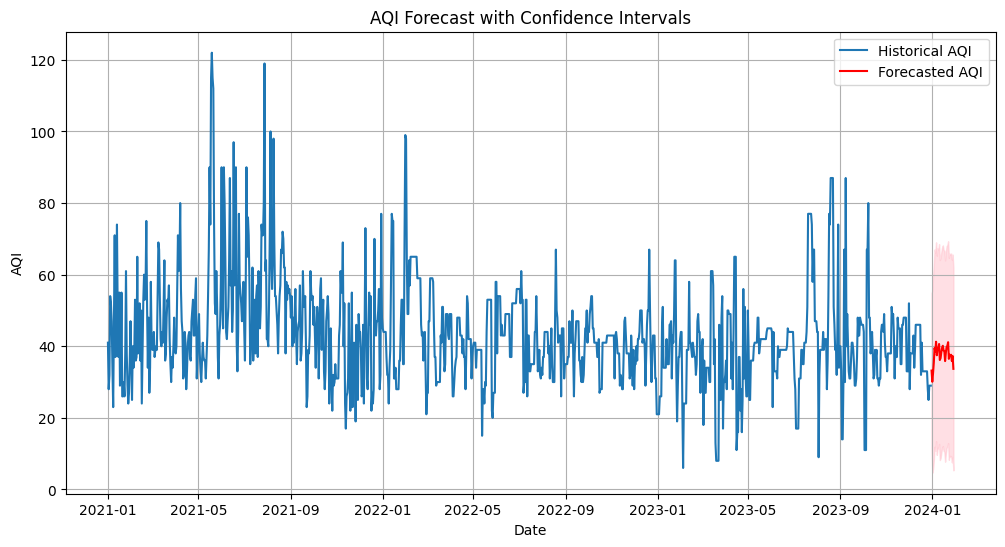

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(new_castle_grouped, label='Historical AQI')
plt.plot(forecast_series, label='Forecasted AQI', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5)
plt.title('AQI Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

Nhìn vào biểu đồ dự doán 30 ngày kế tiếp, ta thấy khoảng tin cậy khá lớn và kết quả khả năng sẽ có độ chính xác thấp. 